In [62]:
"""
CF-PDE system on a ciruclar domain
Model is:

ct = bete*w/(b + w)*c*(1-c-f) - dc*c + Dc Lap(c)
ft = beta(1 - w/(b + w))*f*(1-c-f) - df*f + Df Lap(f)
wt = lambda - mu*w - eta*c*w + Dw Lap(w)

Want to have Dirichlet BC for oxygen and no-flow
for c and f

"""

from __future__ import print_function
from fenics import *
from mshr import *
from dolfin import *
import numpy as np
import sys

T = 20.0            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
k = Constant(dt)

# CF params
beta = 2.2
b = 1.
n = 1.0
dc = 9e-5
df = 9e-5
q = 4.48e-0
eta = 10.54
Dc = 1.32e-8
Df = 1.32e-2
Dw = 1.32e-1
w_r = 1.0

beta = Constant(beta)
b = Constant(b)
n = Constant(n)
dc = Constant(dc)
df = Constant(df)
q = Constant(q)
eta = Constant(eta)
Dc = Constant(Dc)
Df = Constant(Df)
Dw = Constant(Dw)
w_r = Constant(w_r)

# Read mesh from file
# mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')
L = 1.3
# L = float(sys.argv[1])
nx = ny = 20
# mesh = RectangleMesh(Point(-L, -L), Point(L, L), nx, ny)
domain = Circle(Point(0, 0), L)
mesh = generate_mesh(domain, nx)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define boundary condition for oxygen
def boundary(x, on_boundary):
    return on_boundary

# v.sub(2) puts a dirichlet BC only on the
# third component (oxygen)
bc = DirichletBC(V.sub(2), w_r, boundary)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
u = Function(V)
u_n = Function(V)

# Guasian ICs for C and F
u_0 = Expression(('0.1*exp(-100*pow(x[0], 2) - 100*pow(x[1], 2))','0.4*exp(-100*pow(x[0], 2) - 100*pow(x[1], 2))','0.1'), degree = 2, L=L)
u_n = interpolate(u_0, V)

# # Constant initial conditions for checking against ODE
# u_0 = Expression(('0.4','0.3','0.1'), degree = 2)
# u_n = interpolate(u_0, V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)


# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx  \
  + Dc*dot(grad(u_1), grad(v_1))*dx - (beta/( b + u_3 ))*u_3*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx  \
  + Df*dot(grad(u_2), grad(v_2))*dx - beta*(1 - u_3/( b + u_3 ))*u_2*(1-u_1-u_2)*v_2*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx  \
  + Dw*dot(grad(u_3), grad(v_3))*dx + eta*u_1*u_3*v_3*dx

# # Define variational problem
# F = ((u_1 - u_n1) / k)*v_1*dx  \
#   + Dc*dot(grad(u_1), grad(v_1))*dx - (pow(beta,n)/( pow(b,n) + pow(u_3,n) ))*pow(u_3,n)*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
#   + ((u_2 - u_n2) / k)*v_2*dx  \
#   + Df*dot(grad(u_2), grad(v_2))*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  - pow(beta,n)*(1 - pow(u_3,n)/( pow(b,n) + pow(u_3,n) ))*u_2*(1-u_1-u_2)*v_2*dx  \
#   + ((u_3 - u_n3) / k)*v_3*dx  \
#   + Dw*dot(grad(u_3), grad(v_3))*dx - _lambda*v_3*dx + mu*u_3*v_3*dx + eta*u_1*u_3*v_3*dx



# Create VTK files for visualization output
vtkfile_u_1 = File('cf_sys/u_1.pvd')
vtkfile_u_2 = File('cf_sys/u_2.pvd')
vtkfile_u_3 = File('cf_sys/u_3.pvd')

# Create progress bar
# progress = Progress('Time-stepping')
# set_log_level(PROGRESS)
progress = Progress('Time-stepping', num_steps)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    # timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u, bc)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    set_log_level(LogLevel.PROGRESS)
    progress += 1

# Hold plot
#interactive()

### write out function values for anaerobic population
u_1, u_2, u_3 = split(u)

# outfile = open('cf_sys/u out.txt','w')
      
# outfile.close()


print("Argv[1] is ", sys.argv[1])
print("Type of argv[1] is ", type(sys.argv[1]))
# print(len(sys.argv))

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.934e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 4.137e-03 (tol = 1.000e-10) r (rel) = 1.410e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 3.524e-06 (tol = 1.000e-10) r (rel) = 1.201e-07 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 3: r (abs) = 2.290e-12 (tol = 1.000e-10) r (rel) = 7.805e-14 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linea

Time-stepping [=>                                                     ] 2.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.838e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 5.425e-06 (tol = 1.000e-10) r (rel) = 7.933e-05 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.676e-12 (tol = 1.000e-10) r (rel) = 2.452e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving non

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.421e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 6.072e-06 (tol = 1.000e-10) r (rel) = 1.373e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.600e-12 (tol = 1.000e-10) r (rel) = 3.618e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.309e-02 (tol = 

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.237e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 5.009e-06 (tol = 1.000e-10) r (rel) = 1.547e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 4.363e-13 (tol = 1.000e-10) r (rel) = 1.348e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.173e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.601e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 6.326e-06 (tol = 1.000e-10) r (rel) = 2.432e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 9.545e-13 (tol = 1.000e-10) r (rel) = 3.669e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [=====>                                                 ] 10.4%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.549e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.060e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 4.953e-06 (tol = 1.000e-10) r (rel) = 2.404e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.007e-12 (tol = 1.000e-10) r (rel) = 4.886e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.014e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.583e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 3.203e-06 (tol = 1.000e-10) r (rel) = 2.024e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 4.942e-13 (tol = 1.000e-10) r (rel) = 3.123e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [========>                                              ] 14.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.542e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.009e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 8.203e-07 (tol = 1.000e-10) r (rel) = 8.129e-05 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 7.229e-14 (tol = 1.000e-10) r (rel) = 7.164e-12 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.787e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.193e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.678e-06 (tol = 1.000e-10) r (rel) = 2.332e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 4.690e-13 (tol = 1.000e-10) r (rel) = 6.520e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.984e-03 (tol = 

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.245e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 4.473e-06 (tol = 1.000e-10) r (rel) = 8.529e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.641e-12 (tol = 1.000e-10) r (rel) = 3.129e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.207e-03 (tol = 

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.420e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 6.142e-06 (tol = 1.000e-10) r (rel) = 1.133e-03 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 2.153e-12 (tol = 1.000e-10) r (rel) = 3.971e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.470e-03 (tol = 

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.266e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 6.660e-06 (tol = 1.000e-10) r (rel) = 1.063e-03 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.895e-12 (tol = 1.000e-10) r (rel) = 3.024e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.312e-03 (tol = 

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.730e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 6.364e-06 (tol = 1.000e-10) r (rel) = 9.457e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.513e-12 (tol = 1.000e-10) r (rel) = 2.248e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.752e-03 (tol = 

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.885e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 5.873e-06 (tol = 1.000e-10) r (rel) = 8.531e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.221e-12 (tol = 1.000e-10) r (rel) = 1.774e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [==================>                                    ] 34.0%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.889e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.846e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 5.236e-06 (tol = 1.000e-10) r (rel) = 7.648e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 9.456e-13 (tol = 1.000e-10) r (rel) = 1.381e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.834e-03 (tol = 

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.667e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 4.631e-06 (tol = 1.000e-10) r (rel) = 6.946e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 7.299e-13 (tol = 1.000e-10) r (rel) = 1.095e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.646e-03 (tol = 

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.317e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 3.899e-06 (tol = 1.000e-10) r (rel) = 6.173e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 5.144e-13 (tol = 1.000e-10) r (rel) = 8.144e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.288e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).


Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.804e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 3.130e-06 (tol = 1.000e-10) r (rel) = 5.393e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 3.428e-13 (tol = 1.000e-10) r (rel) = 5.906e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.773e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving lin

Time-stepping [=========================>                             ] 46.8%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.464e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 2.717e-06 (tol = 1.000e-10) r (rel) = 4.972e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 2.733e-13 (tol = 1.000e-10) r (rel) = 5.001e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving no

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.083e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 2.314e-06 (tol = 1.000e-10) r (rel) = 4.551e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 2.183e-13 (tol = 1.000e-10) r (rel) = 4.294e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.055e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving lin

Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.741e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.995e-06 (tol = 1.000e-10) r (rel) = 4.208e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.820e-13 (tol = 1.000e-10) r (rel) = 3.839e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.717e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving lin

  Newton iteration 0: r (abs) = 4.410e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.718e-06 (tol = 1.000e-10) r (rel) = 3.897e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.556e-13 (tol = 1.000e-10) r (rel) = 3.528e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.391e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve

  Newton iteration 0: r (abs) = 4.178e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.532e-06 (tol = 1.000e-10) r (rel) = 3.666e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.417e-13 (tol = 1.000e-10) r (rel) = 3.392e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.165e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.064e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.411e-06 (tol = 1.000e-10) r (rel) = 3.473e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.353e-13 (tol = 1.000e-10) r (rel) = 3.329e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Time-stepping [=================================>                     ] 60.4%
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving no

  Newton iteration 0: r (abs) = 4.111e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.328e-06 (tol = 1.000e-10) r (rel) = 3.231e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.304e-13 (tol = 1.000e-10) r (rel) = 3.173e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.128e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.751e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 2.206e-06 (tol = 1.000e-10) r (rel) = 4.642e-04 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.541e-12 (tol = 1.000e-10) r (rel) = 3.243e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.850e-03 (tol = 

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.117e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 1.716e-05 (tol = 1.000e-10) r (rel) = 2.114e-03 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 1.426e-10 (tol = 1.000e-10) r (rel) = 1.756e-08 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 3: r (abs) = 5.275e-16 (tol = 1.000e-10) r (rel) = 6.499e-14 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obt

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.162e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 1: r (abs) = 2.472e-04 (tol = 1.000e-10) r (rel) = 1.144e-02 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 2: r (abs) = 4.314e-08 (tol = 1.000e-10) r (rel) = 1.996e-06 (tol = 1.000e-09)
  Solving linear system of size 2406 x 2406 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 2406 x 2406 system.
  Newton iteration 3: r (abs) = 1.425e-13 (tol = 1.000e-10) r (rel) = 6.594e-12 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obt

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


  Object cannot be plotted directly, projecting to piecewise linears.
  Solving linear system of size 802 x 802 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 802 x 802 system.


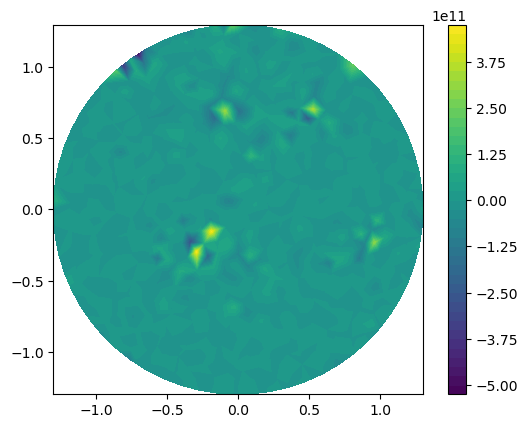

In [64]:
import matplotlib.pyplot as plt
fig = plot(u[1])
plt.colorbar(fig)

In [22]:
V

FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 9869), MixedElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1)))

In [39]:
c = u[0]
f = u[1]

In [40]:
f([L/2,0])

5.114112005254627e-22

In [41]:
u[0]([0,0])

0.9997214918516371

mesh

In [43]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_repr_html_',
 '_repr_svg_',
 '_ufl_domain',
 'bounding_box_tree',
 'cell_name',
 'cell_orientations',
 'cells',
 'color',
 'coordinates',
 'data',
 'domains',
 'geometric_dimension',
 'geometry',
 'hash',
 'hmax',
 'hmin',
 'id',
 'init',
 'init_cell_orientations',
 'init_global',
 'label',
 'mpi_comm',
 'name',
 'num_cells',
 'num_edges',
 'num_entities',
 'num_entities_global',
 'num_faces',
 'num_facets',
 'num_vertices',
 'order',
 'ordered',
 'parameters',
 'rename',
 'rmax',
 'rmin',
 'rotate',
 'scale',
 'smooth',
 'smooth_boundary',
 'snap_boundary',
 'topology',
 'translate',
 'type',
 'ufl_cell',
 'ufl_coordinate_element',
 '

In [44]:
V = FunctionSpace(mesh, "CG", 2)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [46]:
V
dof_coordinates = V.tabulate_dof_coordinates()

In [47]:
dof_coordinates

array([[ 0.29220677, -0.06668952],
       [ 0.29405175, -0.05944384],
       [ 0.29036179, -0.0739352 ],
       ...,
       [-0.29962708,  0.00747688],
       [-0.29075297,  0.03245666],
       [-0.2973937 ,  0.03727295]])

In [51]:
uh = Function(V)
expr = u[2]

In [54]:
xyz = V.tabulate_dof_coordinates()

In [55]:
x = xyz[:,0]

In [66]:
f0 = f([0,0])
f0

8.014576697767408e-22

In [59]:
f0 > 0

True

In [60]:
tol = 1e-3

In [61]:
f0 > tol

False

In [67]:
u[2]([0,0])

  Computed bounding box tree with 3019 nodes for 1510 entities.


277771287.01738304